Imports

In [62]:
from jitcdde import jitcdde, y, t
from parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Define System

In [63]:
# delays
taus = [tau_c, tau_c_hx, tau_hx_c, tau_hx_r, tau_l, tau_r_hx]

# dT/dt for radiator nodes
T_out_rc = (W_rp/mn_rp)*(y(11,t-tau_hx_r)-y(0)) + (hA_rpn/mcp_rpn)*(y(1)-y(0))                  # T_out_rc: y(0)
T_out_air = -((W_rs/mn_rs)+(hA_rsn/mcp_rsn))*y(1) + (hA_rsn/mcp_rsn)*y(0) + (W_rs/mn_rs)*Trs_in # T_out_air: y(1)

# dT/dt for heat exchanger nodes
T_hf1 = -((W_p/mn_p)+(hA_pn/mcp_pn))*y(2) + (hA_pn/mcp_pn)*y(6) + (W_p/mn_p)*y(21,t-tau_c_hx)  # T_hf1: y(2)
T_hf2 = (W_p/mn_p)*(y(2)-y(3)) + (hA_pn/mcp_pn)*(y(6)-y(2))                                    # T_hf2: y(3)
T_hf3 = -((W_p/mn_p)+(hA_pn/mcp_pn))*y(4) + (hA_pn/mcp_pn)*y(7) + (W_p/mn_p)*y(3)              # T_hf3: y(4)
T_hf4 = (W_p/mn_p)*(y(4)-y(5)) + (hA_pn/mcp_pn)*(y(7)-y(4))                                    # T_hf4: y(5)
T_ht1 = (2*hA_pn/mcp_tn)*(y(2)-y(6)) + (2*hA_sn/mcp_tn)*(y(10)-y(6))                           # T_ht1: y(6)
T_ht2 = (2*hA_pn/mcp_tn)*(y(4)-y(7)) + (2*hA_sn/mcp_tn)*(y(8)-y(7))                            # T_ht2: y(7)
T_hc1 = -((W_s/mn_s)+(hA_sn/mcp_sn))*y(8) + (hA_sn/mcp_sn)*y(7) + (W_s/mn_s)*y(0,t-tau_r_hx)   # T_hc1: y(8)
T_hc2 = (W_s/mn_s)*(y(8)-y(9)) + (hA_sn/mcp_sn)*(y(7)-y(8))                                    # T_hc2: y(9)
T_hc3 = -((W_s/mn_s)+(hA_sn/mcp_sn))*y(10) + (hA_sn/mcp_sn)*y(6) + (W_s/mn_s)*y(9)             # T_hc3: y(10)
T_hc4 = (W_s/mn_s)*(y(10)-y(11)) + (hA_sn/mcp_sn)*(y(6)-y(10))                                 # T_hc4: y(11)

# dn/dt
n = (y(22)-beta_t)*y(12)/Lam+lam[0]*y(13)+lam[1]*y(14)+lam[2]*y(15)+lam[3]*y(16)+lam[4]*y(17)+lam[5]*y(18) # n (no source insertion): y(12)

# dC_i/dt (precursor concentrations)
C1 = y(12)*beta[0]/Lam-lam[0]*y(13)-y(13)/tau_c+y(13,t-tau_l)*np.exp(-lam[0]*tau_l)/tau_c  # C1: y(13)
C2 = y(12)*beta[1]/Lam-lam[1]*y(14)-y(14)/tau_c+y(14,t-tau_l)*np.exp(-lam[1]*tau_l)/tau_c  # C2: y(14)
C3 = y(12)*beta[2]/Lam-lam[2]*y(15)-y(15)/tau_c+y(15,t-tau_l)*np.exp(-lam[2]*tau_l)/tau_c  # C3: y(15)
C4 = y(12)*beta[3]/Lam-lam[3]*y(16)-y(16)/tau_c+y(16,t-tau_l)*np.exp(-lam[3]*tau_l)/tau_c  # C4: y(16)
C5 = y(12)*beta[4]/Lam-lam[4]*y(17)-y(17)/tau_c+y(17,t-tau_l)*np.exp(-lam[4]*tau_l)/tau_c  # C5: y(17)
C6 = y(12)*beta[5]/Lam-lam[5]*y(18)-y(18)/tau_c+y(18,t-tau_l)*np.exp(-lam[5]*tau_l)/tau_c  # C6: y(18)

# dT/dt core nodes
T_cg = (hA_fg/mcp_g1)*(y(20)-y(19)) + k_g*P*y(12)/mcp_g1                                             # T_cg: y(19)
T_cf1 = W_f/mn_f*(y(5,t-tau_hx_c)-y(20)) + (k_f1*P*y(12)/mcp_f1) + (hA_fg*k_1*(y(19)-y(20))/mcp_f1)  # T_cf1: y(20)
T_cf2 = W_f/mn_f*(y(20)-y(21)) + (k_f2*P*y(12)/mcp_f2) + (hA_fg*k_2*(y(19)-y(20))/mcp_f2)            # T_cf2: y(21)

# initial reactivity 
rho_initial = 0.0

# jitcdde solver parameters 
t0 = 0.0
tf = 5000.00
T = np.arange(t0,tf,0.01)

Vary temeprature feedback coefficients

In [64]:
# solution vectors
sols = []

# feedbacks
factors_f = np.array([1, 1/2, 1/4, 1/8, 0])#*(-1.0)
factors_g = np.array([1, 1/2, 1/4, 1/8, 0])*(-1.0)

for i in range(len(factors_f)):

    # reinstantiate jitcdde objects
    import sys
    sys.modules.pop('jitcdde')
    from jitcdde import jitcdde, y, t

    # rho y(22)
    a_f_i = factors_f[i]
    a_g_i = factors_g[i]
    rho = a_f_i*(a_f/2)*(T_cf1 + T_cf2) + a_g_i*(a_g)*(T_cg)

    # instantiate jitcdde object
    DDE = jitcdde([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
                T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

    # set initial conditions
    DDE.constant_past([T0_rp, T0_rs, T0_p1,T0_p2, T0_p3, T0_p4, T0_t1, T0_t2, T0_s1, T0_s2, 
            T0_s3, T0_s4, n_frac0, C0[0], C0[1], C0[2], C0[3], C0[4], C0[5], 
            T0_g1, T0_f1, T0_f2,rho_initial])
    
    sol_i = []
    for t_x in T:
        sol_i.append(DDE.integrate(t_x))
    sols.append(sol_i)

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.


Text(0.5, 1.0, 'Reactor Response vs $\\alpha$')

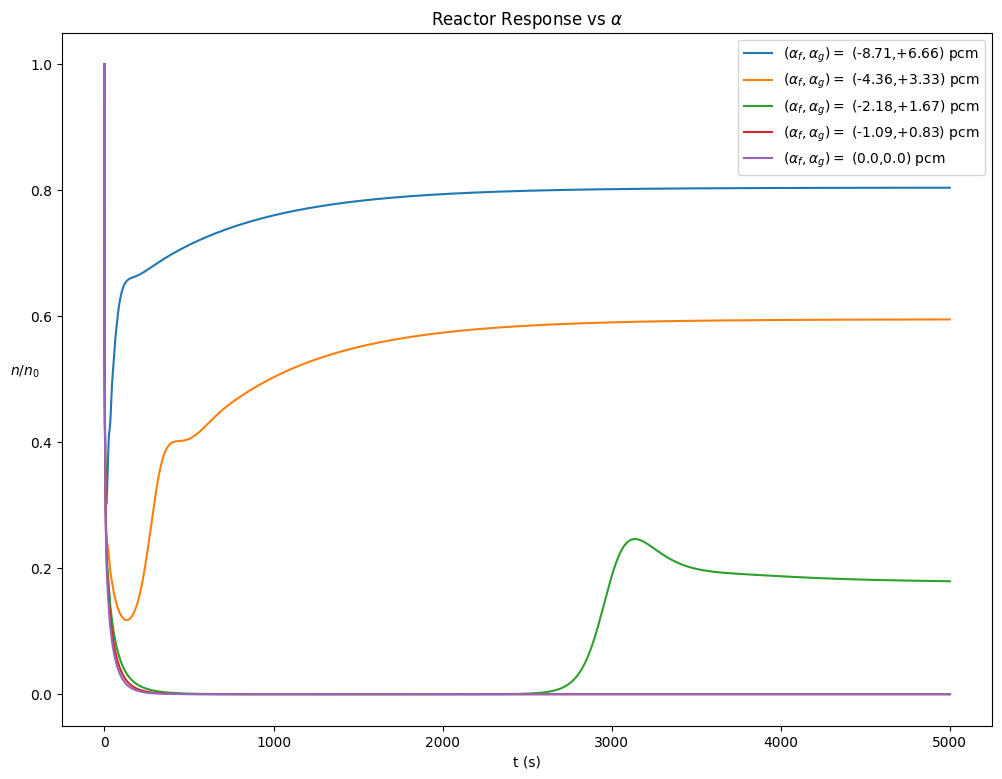

In [66]:
plt.figure(figsize=(12,9))
plt.plot(T,[s[12] for s in sols[0]],label=r"$(\alpha_f,\alpha_g) = $ (-8.71,+6.66) pcm")
plt.plot(T,[s[12] for s in sols[1]],label=r"$(\alpha_f,\alpha_g) = $ (-4.36,+3.33) pcm")
plt.plot(T,[s[12] for s in sols[2]],label=r"$(\alpha_f,\alpha_g) = $ (-2.18,+1.67) pcm")
plt.plot(T,[s[12] for s in sols[3]],label=r"$(\alpha_f,\alpha_g) = $ (-1.09,+0.83) pcm")
plt.plot(T,[s[12] for s in sols[4]],label=r"$(\alpha_f,\alpha_g) = $ (0.0,0.0) pcm")
plt.xlabel("t (s)")
plt.ylabel(r"$n/n_0$",rotation=0)
plt.legend()
#plt.ylim([0,20])
#plt.xlim([0,500])
plt.title(r"Reactor Response vs $\alpha$")